# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding.round(5)

,Price in USDT,Weights in %
Total,1754.88810,1.00000
BTCUSDT,574.96712,0.32764
TRXUSDT,300.54240,0.17126
JASMYUSDT,245.62371,0.13997
SOLUSDT,238.00360,0.13562
OMUSDT,196.84870,0.11217
ETHUSDT,162.29351,0.09248
BBUSDT,36.58835,0.02085
BNBUSDT,0.02070,0.00001
PEPEUSDT,0.00000,0.00000


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [18]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [19]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [20]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [21]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [22]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [23]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

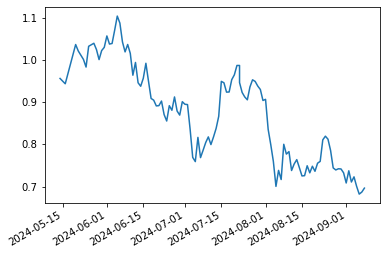

In [24]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [25]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [26]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [27]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'CFXUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT',
       'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT',
       'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT',
       'WBTCUSDT', 'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [28]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [29]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.508965
BTCUSDT,0.400000
PEPEUSDT,0.066875
JASMYUSDT,0.020703
BNBUSDT,0.003457


In [30]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [31]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.875206
OMUSDT,0.124794


## Real Portfolio vs Optimal

In [32]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,574.967119,3.276375e-01,0.000000,0.000000
TRXUSDT,300.542396,1.712601e-01,0.875206,-0.703946
JASMYUSDT,245.623715,1.399655e-01,0.000000,0.000000
SOLUSDT,238.003601,1.356232e-01,0.000000,0.000000
OMUSDT,196.848700,1.121717e-01,0.124794,-0.012622
ETHUSDT,162.293514,9.248083e-02,0.000000,0.000000
BBUSDT,36.588353,2.084939e-02,0.000000,0.000000
BNBUSDT,0.020702,1.179672e-05,0.000000,0.000000
PEPEUSDT,0.000002,9.956190e-10,0.000000,0.000000


In [33]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,574.967119,3.276375e-01,0.400000,-0.072363
TRXUSDT,300.542396,1.712601e-01,0.000000,0.000000
JASMYUSDT,245.623715,1.399655e-01,0.020703,0.119262
SOLUSDT,238.003601,1.356232e-01,0.000000,0.000000
OMUSDT,196.848700,1.121717e-01,0.508965,-0.396793
ETHUSDT,162.293514,9.248083e-02,0.000000,0.000000
BBUSDT,36.588353,2.084939e-02,0.000000,0.000000
BNBUSDT,0.020702,1.179672e-05,0.003457,-0.003445
PEPEUSDT,0.000002,9.956190e-10,0.066875,-0.066875


# Risk Reward Analysis

In [34]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [35]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

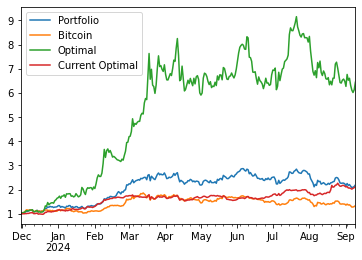

In [36]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [37]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

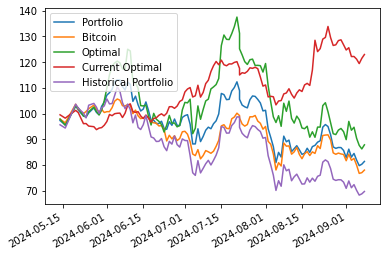

In [38]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [39]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-08-30,86.744613,84.270178,94.182279,128.665576,74.210191
2024-08-31,85.636151,84.056109,92.926805,126.709769,73.287799
2024-09-01,82.823978,81.638368,89.837955,124.706689,70.888670
2024-09-02,86.142417,84.205189,96.929848,125.591728,73.774701
2024-09-03,83.034339,81.830358,93.497197,122.158813,71.119955
2024-09-04,84.470836,82.515248,94.657170,122.175233,72.341855
2024-09-05,81.869129,79.925891,90.368056,121.144219,70.104808
2024-09-06,79.716952,76.707855,87.605367,119.414838,68.257851
2024-09-07,80.265979,76.988639,86.219457,121.458249,68.741021
2024-09-08,81.358558,77.990056,87.813986,122.945161,69.673872


<AxesSubplot:>

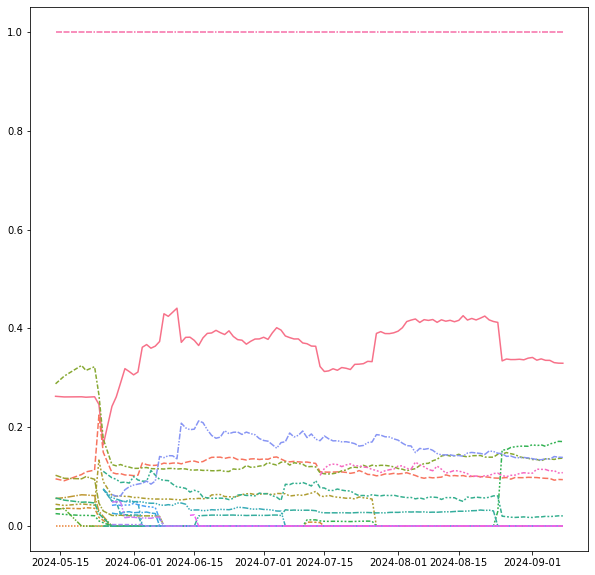

In [40]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weights_ex_post,legend=False,linestyle='solid')

## Volatilities

In [41]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.778715
dtype: float64

In [42]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.485
dtype: float64

In [43]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.481632
Bitcoin            0.449675
Optimal            0.780056
Current Optimal    0.334135
dtype: float64

In [44]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.2550923633591636

## Risk Contribution

In [45]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.000411,0.000743,0.000888,0.000005,0.000883
BTCUSDT,0.016523,0.058314,0.141982,0.053170,0.088812
JASMYUSDT,0.002603,0.004575,0.010398,0.000870,0.009528
OMUSDT,0.966970,0.917056,0.796796,0.705721,0.091075
PEPEUSDT,0.013494,0.019311,0.049935,0.012741,0.037194


In [46]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.537807,0.310530,0.266421,0.085079,0.181343
TRXUSDT,-0.403143,0.223699,0.045089,0.012763,0.032326
JASMYUSDT,0.291517,0.125804,0.249281,0.087833,0.161448
SOLUSDT,0.316615,0.123453,0.174828,0.040236,0.134593
OMUSDT,-0.155923,0.134915,0.136057,0.039785,0.096272
ETHUSDT,0.277773,0.072407,0.087271,0.011144,0.076128
BBUSDT,0.135354,0.009192,0.041052,0.003798,0.037254


# Value At Risk

## Historical

In [47]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06429509621508919, -0.09003631184106463)

In [48]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05021500591232981, -0.06449086861384838)

In [49]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [50]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012198
TRXUSDT     -0.001854
JASMYUSDT   -0.011217
SOLUSDT     -0.011791
OMUSDT      -0.009065
ETHUSDT     -0.001901
BBUSDT      -0.002028
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050054
Name: 2024-08-11 00:00:00, dtype: float64

In [51]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.016765
TRXUSDT     -0.004198
JASMYUSDT   -0.014124
SOLUSDT     -0.011006
OMUSDT      -0.008456
ETHUSDT     -0.005783
BBUSDT      -0.002097
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.062428
dtype: float64

## Parametric

In [52]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.08082626690088855, -0.10359692694180332)

In [53]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.05025379188039713, -0.06441146678673164)

## Multivariate

In [54]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07172231973974157, -0.0916236194089355)

In [55]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05010899740151144, -0.06312669681124816)

In [56]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.013582
TRXUSDT     -0.001552
JASMYUSDT   -0.012150
SOLUSDT     -0.009017
OMUSDT      -0.007061
ETHUSDT     -0.004982
BBUSDT      -0.002026
Portfolio   -0.050371
dtype: float64

## Copulas

### Gaussian Copula

In [57]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07223877062977548, -0.09350160038722641)

In [58]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.049801513597921544, -0.06281666544551899)

In [59]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013153
TRXUSDT     -0.002067
JASMYUSDT   -0.012413
SOLUSDT     -0.009252
OMUSDT      -0.007085
ETHUSDT     -0.004294
BBUSDT      -0.002021
Portfolio   -0.050284
dtype: float64

### Student Copula

In [60]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0726039430107574, -0.09236890938220685)

In [61]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05158915452781803, -0.06504283452835406)

In [62]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.014492
TRXUSDT     -0.003065
JASMYUSDT   -0.012439
SOLUSDT     -0.008797
OMUSDT      -0.005904
ETHUSDT     -0.004857
BBUSDT      -0.001767
Portfolio   -0.051321
dtype: float64

### Gumbel Copula

In [63]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.15138796745103766, -0.21095011499995797)

In [64]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.056029339988682876, -0.07666691173977258)

In [65]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.018605
TRXUSDT     -0.002967
JASMYUSDT   -0.017626
SOLUSDT     -0.007693
OMUSDT      -0.005812
ETHUSDT     -0.002315
BBUSDT      -0.000780
Portfolio   -0.055798
dtype: float64

### Monte Carlo

In [66]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [67]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08296867262498177, -0.10317982495080595)

In [68]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0505577641150597, -0.06299219637995755)

In [69]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.013117
TRXUSDT     -0.002223
JASMYUSDT   -0.012122
SOLUSDT     -0.009629
OMUSDT      -0.007771
ETHUSDT     -0.004332
BBUSDT      -0.002068
Portfolio   -0.051261
dtype: float64

## VaR Violation

In [70]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.062066,-0.113428,-0.094546,-0.025247
2024-01-15,-0.062066,-0.113425,-0.098087,0.014843
2024-01-16,-0.062066,-0.114290,-0.092225,0.063983
2024-01-17,-0.062066,-0.116695,-0.100625,-0.036995
2024-01-18,-0.062066,-0.118827,-0.102035,-0.036174
...,...,...,...,...
2024-09-05,-0.058863,-0.095500,-0.096333,-0.045312
2024-09-06,-0.058863,-0.094762,-0.098447,-0.030572
2024-09-07,-0.058863,-0.084858,-0.087814,-0.015820
2024-09-08,-0.058863,-0.084727,-0.089286,0.018494


In [71]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.026945,-0.076595,-0.067847,-0.017249
2024-05-29,-0.023626,-0.074138,-0.066701,-0.008351
2024-05-30,-0.023626,-0.063820,-0.057894,0.032815
2024-05-31,-0.023626,-0.062397,-0.054653,0.015030
2024-06-01,-0.023626,-0.062347,-0.057539,0.026217
...,...,...,...,...
2024-09-05,-0.049485,-0.069813,-0.073360,-0.030800
2024-09-06,-0.049485,-0.070522,-0.076739,-0.026288
2024-09-07,-0.049485,-0.057151,-0.068479,0.006887
2024-09-08,-0.049485,-0.057614,-0.066770,0.013612


<AxesSubplot:>

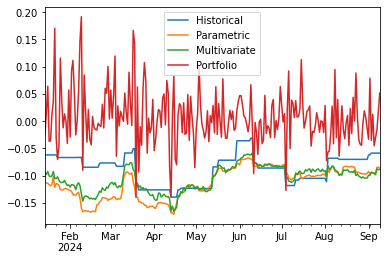

In [72]:
var_data.plot()

<AxesSubplot:>

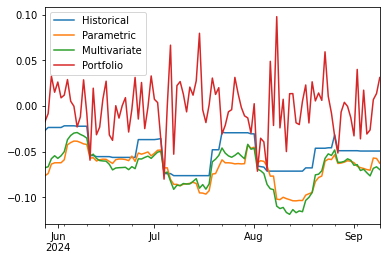

In [73]:
current_var_data.plot()

In [74]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020833,0.008333,0.0125
Kupiec Stat,5.458059,13.265283,10.032913
P-value,0.019478,0.00027,0.001538


In [75]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.07619,0.038095,0.028571
Kupiec Stat,1.315936,0.340129,1.19268
P-value,0.251323,0.559755,0.27479


## Principal Component Analysis

### Historical PCA

In [76]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78915945, 0.06450054, 0.05319282, 0.04863398, 0.04451322])

In [77]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

1000SATSUSDT    0.023539
AAVEUSDT        0.013975
ADAUSDT         0.014042
ALGOUSDT        0.015505
APTUSDT         0.014643
                  ...   
WLDUSDT         0.021076
XECUSDT         0.015027
XLMUSDT         0.009445
XRPUSDT         0.009079
XTZUSDT         0.014136
Name: PC1, Length: 66, dtype: float64

<AxesSubplot:>

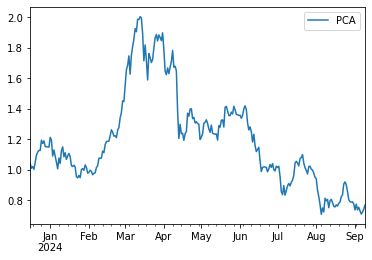

In [78]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

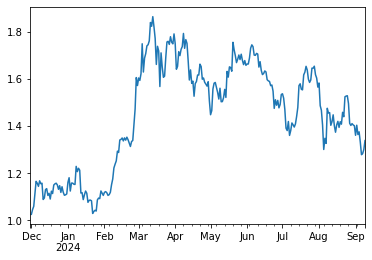

In [79]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [80]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA             0.000000
SANDUSDT        0.298250
ADAUSDT         0.325787
XTZUSDT         0.329698
ALGOUSDT        0.345293
                  ...   
1000SATSUSDT    0.979828
PEPEUSDT        0.992270
FLOKIUSDT       1.000761
WLDUSDT         1.016909
OMUSDT          1.305201
Length: 67, dtype: float64

<AxesSubplot:>

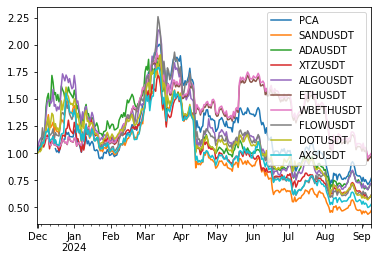

In [81]:
(1+comparison[distances.index[:10]]).cumprod().plot()

### Current PCA

In [82]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67027795, 0.14009259, 0.08454939, 0.07243083, 0.03264925])

In [83]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063314
TRXUSDT      0.015945
JASMYUSDT    0.155438
SOLUSDT      0.102908
OMUSDT       0.100527
ETHUSDT      0.085608
BBUSDT       0.246957
BNBUSDT      0.068300
PEPEUSDT     0.161004
Name: PC1, dtype: float64

<AxesSubplot:>

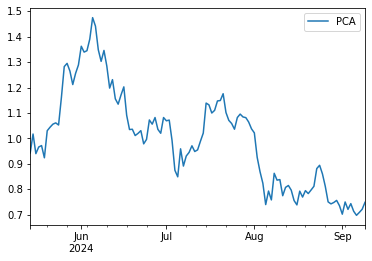

In [84]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

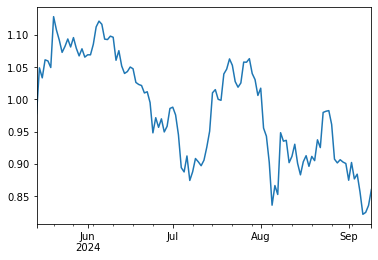

In [85]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [86]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.325749
SOLUSDT      0.335832
BNBUSDT      0.352091
BTCUSDT      0.357803
JASMYUSDT    0.417739
PEPEUSDT     0.452809
OMUSDT       0.509694
TRXUSDT      0.526738
BBUSDT       0.606440
dtype: float64

<AxesSubplot:>

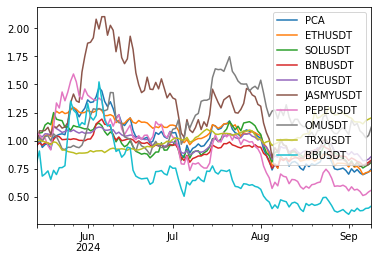

In [87]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [88]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.947583
BBUSDT       1.734292
JASMYUSDT    1.282695
SOLUSDT      1.169152
OMUSDT       1.000100
BTCUSDT      1.000000
ETHUSDT      0.956032
BNBUSDT      0.671480
TRXUSDT      0.288422
Name: BTCUSDT, dtype: float64

In [89]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.954235
PEPEUSDT     1.799434
OMUSDT       1.519002
ETHUSDT      1.340065
SOLUSDT      1.231111
BTCUSDT      1.000000
JASMYUSDT    0.989173
BNBUSDT      0.716730
TRXUSDT      0.371378
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=7

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,JASMYUSDT,SOLUSDT,OMUSDT,ETHUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-20,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-05-27,0.000000,0.000000,0.405921,0.000000,0.000000,0.000000,0.122004,0.000000,0.472076
2024-06-03,0.000000,0.000000,0.185125,0.000000,0.814875,0.000000,0.000000,0.000000,0.000000
2024-06-10,0.000000,0.841078,0.047817,0.000000,0.111105,0.000000,0.000000,0.000000,0.000000
2024-06-17,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.979868,0.000000,0.000000,0.020132,0.000000,0.000000,0.000000,0.000000
2024-07-01,0.000000,0.804372,0.000000,0.146827,0.047122,0.000000,0.001680,0.000000,0.000000
2024-07-08,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2024-07-15,0.048111,0.606760,0.002957,0.000000,0.000000,0.000000,0.037292,0.304881,0.000000
2024-07-22,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
